In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
def target_pdf(x):
    qx = np.exp(- x**2 / 2) / np.sqrt(2 * np.pi)
    return qx

def MHprocedure(x0, sig):
    xpre = np.random.normal(loc = x0, scale = sig) # chose normal distribution as proposal density
    alphapre = target_pdf(xpre) / target_pdf(x0) # alphapre = (target_pdf(xpre) * proposal(x0|xpre)) / (target_pdf(x0) * proposal(xpre|x0))
    alpha = min(1, alphapre)
    # since normal distribution is symmetric, proposal(x0|xpre) and proposal(xpre|x0) cancel out

    u = np.random.rand()
    if u <= alpha:
        x1 = xpre
        acc = 1
    else:
        x1 = x0
        acc = 0
    return x1, acc

def run_MCMC(x0, sample_size, sig = 1, burnin = 100):
    # Burn-in Periods
    for _ in range(burnin):
        x0, _ = MHprocedure(x0, sig)
    
    X = np.zeros(sample_size)
    X[0] = x0
    Acp = 0
    for i in range(1, sample_size):
        xi = X[i - 1]
        X[i], acc0 = MHprocedure(xi, sig)
        Acp += acc0
    
    Accrate = Acp / (sample_size - 1)
    
    return X, Accrate

In [3]:
def score_1Dnormal(x):
    # Sq(x) = q'(x) / q(x) = -x
    return -x

def kernel_function(x, y):
    return np.exp(- (x - y) ** 2 / 2)
    # gradient wrt x is -(x - y) * kernel_function(x, y)
    # gradient wrt y is (x - y) * kernel_function(x, y)
    # second derivative wrt x, y is (1 -(x - y)^2) * kernel_function(x, y)


def UqMatrix(X):
    """
    param x: array with length n
    """
    n = len(X)
    UM = np.zeros((n, n), dtype=np.float64)
    for i in range(n):
        xi = X[i]
        for j in range(n):
            xj = X[j]
            kxy = kernel_function(xi, xj)
            uij = (- xi) * kxy * (- xj) + (- xi) * (xi - xj) * kxy + (- xj) * (-1 * (xi - xj)) * kxy + (1 - (xi - xj) ** 2) * kxy
            UM[i, j] = uij
    
    return UM


def KSD_1D(X, U):
    """
    param X: a 1D array with length n
    param U: a n x n array
    """
    n = len(X)
    diag_sum = sum(U.diagonal())
    matrix_sum = sum(sum(U))
    KSD = (matrix_sum - diag_sum) / (n * (n - 1))
    return KSD

In [4]:
def Bootstrap_1D(X, U, m = 50, epochshow = False):
    """
    param X: a 1D array with length n
    param U: a n x n array
    """
    n = len(X)
    multi_prob = np.repeat((1 / n), n)

    epoch = 0
    Sstar = np.zeros(m, dtype = np.float64)
    for i in range(m):
        Weight = np.random.multinomial(n, multi_prob)
        Wadjust = (Weight - 1) / n
        WMatrix = np.outer(Wadjust, Wadjust)
        SMatrix = WMatrix * U
        diag_sum = sum(SMatrix.diagonal())
        matrix_sum = sum(sum(SMatrix))
        Si = matrix_sum - diag_sum
        Sstar[i] = Si
        if (epochshow == True) & ((i+1) % 100 == 0):
            print(f"we are in epoch {i+1}")

    return Sstar

def approx_pvalue(S, Sstar):
    """
    param S: unbiased estimation of KSD, scalar
    param Sstar: unbiased m bootstrap sample KSD
    """
    m = len(Sstar)
    TFarray = Sstar[Sstar >= S]
    count = len(TFarray)
    return count / m

In [9]:
meanvalue = np.linspace(0, 0.5, 6)
n_mean = len(meanvalue)
mean_p = np.zeros(n_mean, dtype=np.float64)
for i in range(n_mean):
    mean = meanvalue[i]
    p = np.zeros(10, dtype=np.float64)
    for j in range(10):
        Gaussian_X = np.random.normal(mean, 1, 100) # N(i, 1)
        Umatrix = UqMatrix(Gaussian_X)
        KSD = KSD_1D(Gaussian_X, Umatrix)
        KSDstar = Bootstrap_1D(Gaussian_X, Umatrix, m = 1000)
        p[j] = approx_pvalue(KSD, KSDstar)
    mean_p[i] = p.mean()
    print(f"finish N({i / 10}, 1)")
    print(f"mean pvalue: {mean_p[i]}")

finish N(0.0, 1)
mean pvalue: 0.4502
finish N(0.1, 1)
mean pvalue: 0.2846
finish N(0.2, 1)
mean pvalue: 0.16730000000000003
finish N(0.3, 1)
mean pvalue: 0.027600000000000003
finish N(0.4, 1)
mean pvalue: 0.0261
finish N(0.5, 1)
mean pvalue: 0.0026000000000000003


[0.4502 0.2846 0.1673 0.0276 0.0261 0.0026]


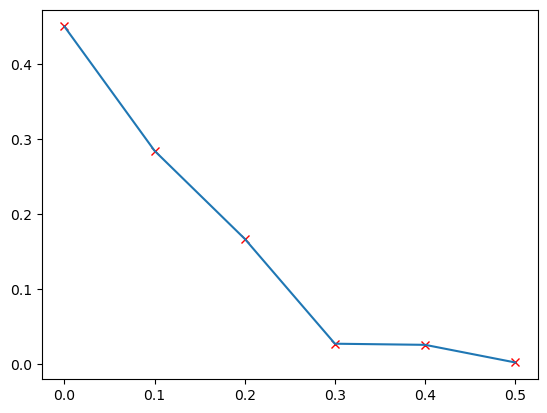

In [10]:
print(mean_p)
plt.plot(meanvalue, mean_p, 'rx')
plt.plot(meanvalue, mean_p)

In [7]:
mean_p1 = np.zeros(n_mean, dtype=np.float64)
for i in range(n_mean):
    mean = meanvalue[i]
    p = np.zeros(10, dtype=np.float64)
    for j in range(10):
        Gaussian_X = np.random.normal(mean, 1, 1000) # N(i, 1)
        Umatrix = UqMatrix(Gaussian_X)
        KSD = KSD_1D(Gaussian_X, Umatrix)
        KSDstar = Bootstrap_1D(Gaussian_X, Umatrix, m = 1000)
        p[j] = approx_pvalue(KSD, KSDstar)
    mean_p1[i] = p.mean()
    print(f"finish N({i / 10}, 1)")
    print(f"mean pvalue: {mean_p1[i]}")


finish N(0.0, 1)
mean pvalue: 0.43129999999999996
finish N(0.1, 1)
mean pvalue: 0.045
finish N(0.2, 1)
mean pvalue: 0.0
finish N(0.3, 1)
mean pvalue: 0.0
finish N(0.4, 1)
mean pvalue: 0.0
finish N(0.5, 1)
mean pvalue: 0.0


[0.4313 0.045  0.     0.     0.     0.    ]


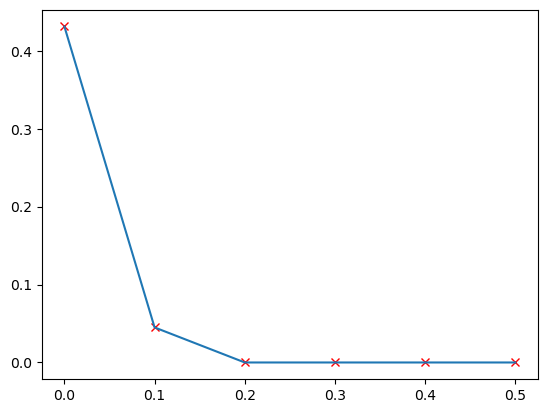

In [8]:
import matplotlib.pyplot as plt
print(mean_p1)
plt.plot(meanvalue, mean_p1, 'rx')
plt.plot(meanvalue, mean_p1)